# Dimensionality Reduction Via Principle Component Analysis 

In Machine Learning, high-dimensional feature spaces often suffer from the **curse of dimensionality**, where points tend to be so far apart from each other that models may need to see exponentially more data points in order to learn effectively. Data formats that tend toward very high dimensions include **images** (many pixels) and **text** (many unique words). In the latter case, high-dimensionality can be especially severe when one cares about usage of a group of semantically similar words much more than usage of hyper-specific single words (e.g. topic modeling or text recommendation). 

**Dimensionality reduction** methods are used for compressing a large number of features into a (much) smaller representation in a way that preserves as much information as possible for that choice of size. 

Key benefits of dimensionality reduction include:

1. **Model Improvements**: some models, especially distance-based ones like *KNN, SVM, and k-means clustering*, can perform very poorly under the the condition of sparse, high-dimensional feature spaces. Other models like *linear/logistic regression* and *neural networks* can struggle in the presence of excess multicolinearity among features.

2. **Speed**: Some algorithms scale very poorly with respect to the number of features (looking at you, *KNN, SVM, k-means*!), so dimensionality reduction can yield a dramatic speed-up in training and prediction time.
3. **Storage**: Outside of sparse matrix formats, fewer feature columns simply means less data to store.
4. **Visualization**: We can visualize feature representations that live in 2 or 3 dimensions, but not beyond that :)

The main downside of dimensionality reduction is that it **essentially always involves loss of information**. The information lost can be extraneous or noisy (good), but it might also include predictive signal that a model would benefit from accessing (bad). 

This lecture introduces the most common framework for dimensionality reduction, **Principle Component Analysis**. 

## Section 1: Principle Component Analysis: Motivated, Explained, and Derived

Let's start by generating some highly colinear 2-dimensional "feature" data and think about the amount of *information* that's truly present in that data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set()

def make_colinear_data_2D(noise=.01):
    '''
    Generate 100 random samples of 2D data, where the 2nd dimension is linearly
    dependent on the first with a noise factor
    '''
    
    np.random.seed(42)

    x1 = np.random.normal(loc=40, scale=8, size=100)
    x2 = x1 - 10 + np.random.normal(scale=noise, size=100)
    
    return np.column_stack([x1, x2])

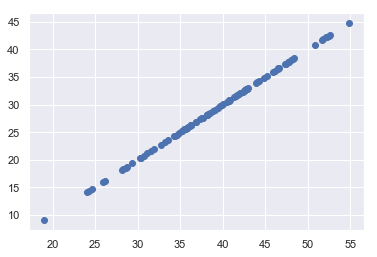

In [2]:
X = make_colinear_data_2D()
plt.scatter(X[:,0], X[:,1])

-----
**Question**: Do think we really need 2 features to represent the information in this feature set? Why or why not?

The answer is that we do need both features, but can do *almost* as well with just 1. We can get close to mapping x1 perfectly to x2, but the added noise means there's a bit of variance in x2 that x1 can't explain. 

We'll start to **use the terms information and variance (statistically) interchangeably** - you can think of variance as our quantification of "total information" in the context of a feature.  

------

**Another Question**: Can you think of a geometric way to represent this data nearly perfectly in 1 dimension?

It's a line of course. Instead of thinking in terms of x1 or x2, what we really want to get at is a simple representation of the information in that line. Thinking about it visually, couldn't we just rotate the orientation of our plot axes to make that line the x axis and use that axis as our primary feature? The secondary, less important feature that we may want to drop would be a y axis representing the noise spread around the line.   

More generally, it would be great if we had a way to **systematically convert features to lower dimension representations through axis rotation that compresses information into a few top features**. This is exactly what PCA does! Let's see it in action then talk about the how. 

In [3]:
def pca_transform(X):
    '''
    Project data matrix X onto its principle components 
    '''
    
    # subtract mean from each column (demean)
    X_centered = X - np.mean(X, axis=0)
    
    # perform eigenvector decomposition of covariance matrix of X_centered
    _, Q = np.linalg.eig(np.cov(X_centered, rowvar=0))
    
    # project X onto the extracted eigenvectors (columns of Q)
    return np.matmul(X,Q)

def plot_X_and_proj(X, X_proj):
    '''
    Plot data matrix X against its projection onto principle components
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    fig.tight_layout()

    ax[0].scatter(X[:,0], X[:,1], c='b')
    ax[0].set_title('Original Data X')
    
    ax[1].scatter(X_proj[:,0], X_proj[:,1], c='r')
    ax[1].set_title('X Projected Onto Principle Components')

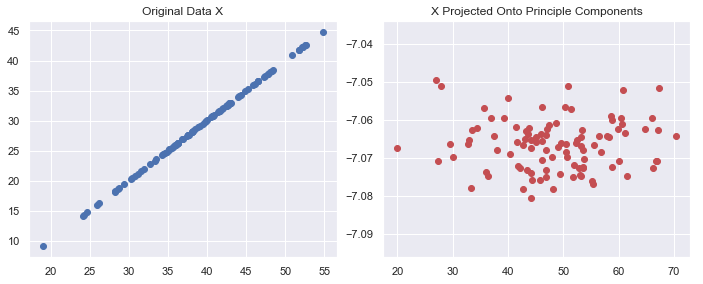

In [4]:
X_proj = pca_transform(X)
plot_X_and_proj(X, X_proj)

In our new principle component space, we have all the same information as the original data. But the great benefits of this new space are:

* We can cleanly rank features by their information (variance)
* With these ranks, we can drop dimensions off the least informative features and **lose the minimal amount of information possible for that level of feature reduction**. This is the same as the new features being completely uncorrelated with each other.

When we add more noise to the linear relationship, you can visually note how the variance/information in the secondary (y-axis) principle component goes up:

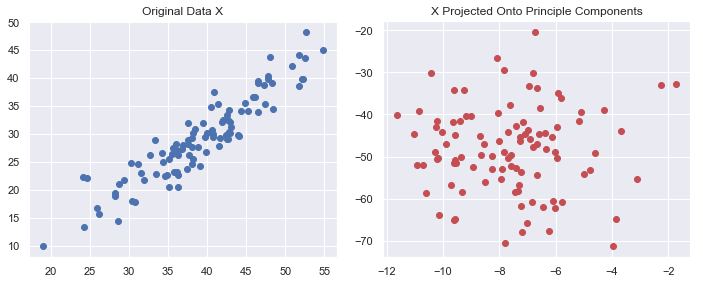

In [5]:
X = make_colinear_data_2D(noise=3)

X_proj = pca_transform(X)
plot_X_and_proj(X, X_proj)

You can see similarly what happens with no noise! The 2nd principle component is now irrelevant.

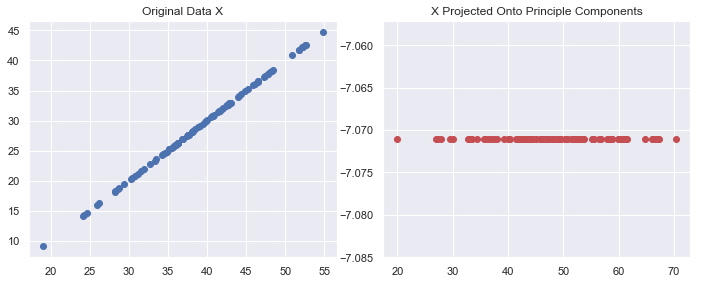

In [6]:
X = make_colinear_data_2D(noise=0)

X_proj = pca_transform(X)
plot_X_and_proj(X, X_proj)

### Let's dig into the math a bit!

As in the charts above, we can explicitly frame our goal:

**GOAL: rotate the feature space so that our new feature dimensions have 0 covariance**. 

In linear algebra terms, this amounts to finding a *change of basis* matrix $Q$ to apply to $X$ such that the covariance matrix of $XQ$ is a diagonal matrix (i.e. has non-zero entries only on the diagonal). Covariance matrices are defined as below, where the entry at $ij$ is given by $Cov(X_i, X_j)$ (covariance of 2 feature columns).   

$$
  Cov(X) = 
  \begin{bmatrix}
    Var(X_1) & & Cov(X_1,X_p) \\
    & \ddots & \\
    Cov(X_p,X_1) & & Var(X_p)
  \end{bmatrix}
$$

So if such a matrix is diagonal, it means that all of the pairwise feature covariances are 0, which is our goal for the **new feature space $XQ$, i.e. our principle components.** 

-----
We'll need to utilize eigenvectors, so let's review:

**Definition: an eigenvector** of a matrix $A$ is any vector $\textbf{v}$ that satisfies $A\textbf{v} = \lambda\textbf{v}$ for some **eigenvalue** $\lambda$. In english, this means that applying the linear transformation $A$ to $\textbf{v}$ has the effect of multiplying it by a constant and not rotating its orientation in space (beyond possibly flipping it).  

-----

-----
**Key Fact**: For a *symmetric* $p{\times}p$ matrix $A$, we can write $A = Q \Lambda Q^{T}$, where:

$Q$ is the $p{\times}p$ matrix whose columns are the eigenvectors $\bf{q_{1}}, \dots, \bf{q_p} $ of $A$;

$\Lambda$ is the $p{\times}p$ *diagonal* matrix of corresponding eigenvalues of $A$, like below:  

$$
  \Lambda =  
  \begin{bmatrix}
    \lambda_{1} & & 0 \\
    & \ddots & \\
    0 & & \lambda_{p}
  \end{bmatrix}
$$

It's not too bad to prove this by working out that $AQ = Q\Lambda$, then using the fact that $Q^{-1} = Q^T$ for symmetric $A$. This process is called **diagonalization** or **eigenvector decomposition**.

-----

**Why do we care about this key fact?** Because, assuming that the columns of $X$ have mean 0, $Cov(X) = \frac{1}{n-1}X^TX$ is a symmetric matrix that we can apply the fact to! For simplicity, we'll drop the leading constant since it's irrelevant to the core computations. We choose $Q$ to be the eigenvectors of $X^TX$ as in the fact, and **project $X$ onto $Q$ to get the principle components $XQ$**. This is our new p-dimensional representation of all the information in $X$.

The big reveal comes when we compute the covariance matrix of the principle components $XQ$. 

$$ (XQ)^T(XQ) = Q^TX^TXQ $$

$$  = Q^T(Q \Lambda Q^T ) Q$$

$$ = \Lambda$$

The last substitution is valid because $Q^T = Q^{-1}$. This computation means that the **features of $XQ$ have 0 covariance**, since the only non-zero entries in the matrix $\Lambda$ are along the diagonal. This is exactly what we wanted for our new representation of $X$. 

**RECAP:** our steps were:

1. **Perform eigenvector decomposition** of the covariance matrix of (demeaned) $X$ i.e. obtain 

    $$X^TX = Q \Lambda Q^{T} $$
    
2. Select $Q$ from this decomposition to use as a change of basis, i.e. project $X$ onto the eigenvectors $Q$ to get the **principle components $XQ$**

Go back and check the function we wrote early on to see these steps done in code.

We showed above that this selection of $XQ$ ensures the property we want, namely that the different column dimensions of $XQ$ have zero covariance. This means that $XQ$ gives a representation of all of the information in $X$, but where (linear) information is maximally compressed into individual feature columns. 

If you like thinking geometrically, we can equivalently think of this process as projecting $X$ onto its **directions of maximum variance**, which are the **eigenvectors of the covariance matrix of X**. Visually, in the 2D cases above these directions of maximum variance are the best fit line and the line perpendicular to it (directions of maximum variance are orthogonal).  

The key application of this result is that we can now perform much better **dimensionality reduction** by simply dropping the PC feature columns that carry the least information (i.e. *lowest variance columns*). We'll show exactly how to do this in the next section.

-----
#### Variance explained ratios

In fact, since the following holds for the **trace** (sum of matrix diagonal) of the covariance matrix when we apply eigenvector decomposition:

$$ tr(Cov(X)) = tr(Q \Lambda Q^{T}) = tr(\Lambda) $$

we get $$ \sum_{i=1}^{p} Var(X_i) = \sum_{i=1}^{p} \lambda_i $$ 

and can naturally define $ \frac{\lambda_i}{\sum_{i=1}^{p} \lambda_i} $ as the **ratio of variance explained by the ith principle component**. The eigenvalue magnitudes $\lambda_i$ then let us sort PCs in descending order of information, and the explained variance ratios let us quantify the % of information captured by each component.

-----

#### Can Sklearn do it for us?

Of course! In terms of information, the result below is exactly the same as our last manual example. The red plot is flipped, but this is just a quirk of the linear algebra computations and irrelevant from an information perspective.

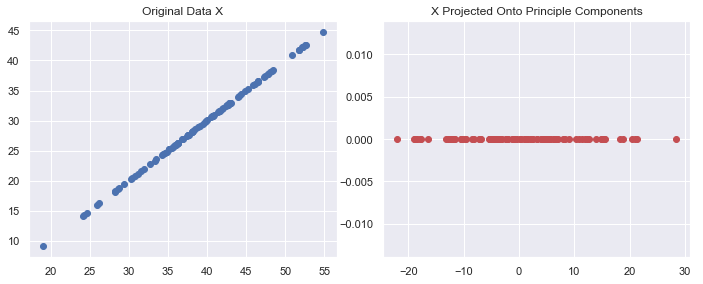

In [7]:
from sklearn.decomposition import PCA

# note you can also set n_components directly here if you want
# a lower dimensional projection
pca = PCA()

X = make_colinear_data_2D(noise=0)
X_proj = pca.fit_transform(X) # sklearn fit_transform instead of our version
plot_X_and_proj(X, X_proj)

## Section 2: Principle Component Analysis Applied

In this context, **raw word count features arguably carry too much and too granular information to be tractable for human interpretation**. When trying to understand the ways that different documents are similar or different, we rarely think in terms of the thousands of different words that might occur. We think more conceptually, in terms of topics or broad characteristics, almost as if our brains use an internal semantic model that projects statistically related words onto concept dimensions (yes, this language is meant to evoke PCA).

We'll build more on this idea in later lectures, but for now we're going to see how PCA can aid in **detection of structure in text data** - i.e. as a first step to perform before clustering. We'll use sample data that we have labels for (positive and negative sentiment) from amazon reviews, and see if we do a decent job recovering the labels with purely unsupervised methods (clustering). 

Our pipeline will ultimately look like this:

* Raw text -> Tf-idf vectorizer -> PCA (choose number of components) -> k-means clustering

We can start with the first 3 steps, run PCA, and study **variance explained** plots to get a feel for the amount of information carried by the first $n$ principle components.

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import  TfidfVectorizer 

df = pd.read_csv("amazon_cells_labelled.txt", 
                 sep='\t', names=['text', 'sentiment'])

tfidf = TfidfVectorizer()

# note you can also set n_components directly here if you want
# a lower dimensional projection
pca = PCA()

X = tfidf.fit_transform(df.text)
X = pca.fit_transform(X.toarray())

We'll define a handy function for creating the variance explained plots then go ahead and run it on this PCA fit. These **percent of variance explained** numbers correspond to the eigenvalue ratios $\frac{\lambda_i}{\sum{\lambda_i}}$ that we mentioned above - note that PCs are sorted in descending order of eigenvalue magnitude (and hence variance explained).

In [9]:
def show_variance_explained_plots(pca):
    
    var_exp_array = pca.explained_variance_ratio_
    n_comps = var_exp_array.shape[0] 
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    ax[0].fill_between(range(n_comps), var_exp_array)
    ax[0].set_title('Variance Explained by Nth Principle Component')
    
    ax[1].fill_between(range(n_comps), np.cumsum(var_exp_array))
    ax[1].set_title('Cumulative Variance Explained by N Components')
    
    plt.show()

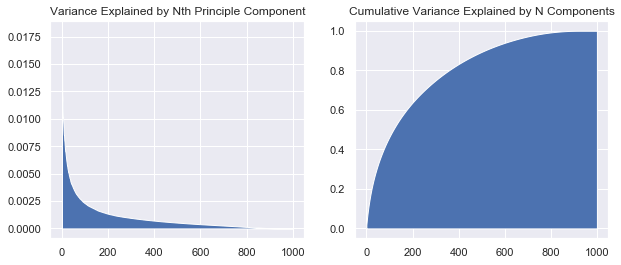

In [10]:
show_variance_explained_plots(pca)

These plots let us look at the variance carried by each PC (in descending order of variance, the order in which principle components will typically be sorted) as well as cumulative variance explained by the top x components. They can provide useful heuristics for selecting the number of principle components to reduce to, for example:

* Detect an **elbow** or sudden drop-off in the variance explained by nth component plot, which can indicate that components beyond this point become much less informative / are closer to noise  
* Choose a **natural point in cumulative variance explained**, e.g. *80 percent explained by the top 400 PCs*

But remember that if you're using PCA as a pipeline to a supervised model, a good option on hand is to **choose number of components with cross-validation** ;) 

In this particular case, there's no especially clear cutoff to use. Let's see what happens when we fit a 2-means cluster model on *all principle components $X$* (equivalent information to all tf-idf features), and display some statistics about how the cluster labels compare with the true sentiment labels. 

In [11]:
from sklearn.cluster import KMeans

k_means_cluster = KMeans(n_clusters=2, random_state=42)

cluster_labels = k_means_cluster.fit_predict(X)

Percentage of 1s in cluster 0: 0.9863013698630136
Percentage of 1s in cluster 1: 0.4617044228694714


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


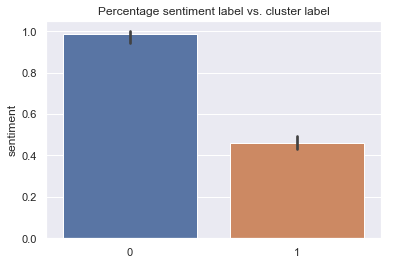

In [12]:
def show_cluster_stats(cluster_labels, sentiment):
    
    print('Percentage of 1s in cluster 0: {}'
          .format(np.mean(sentiment[cluster_labels == 0])))
    
    print('Percentage of 1s in cluster 1: {}'
          .format(np.mean(sentiment[cluster_labels == 1])))
    
    sns.barplot(cluster_labels, sentiment)
    plt.title('Percentage sentiment label vs. cluster label')

show_cluster_stats(cluster_labels, df.sentiment)

Cool, so just by clustering the raw tf-idf features we can do an ok job finding clusters that separate the data. From these distributions, it seems like we're good at identifying obvious positive sentiment, but that there are harder cases that get more mixed with negatives.

Hang on though, the whole point of this was dimensionality reduction! Might we be lucky enough that the information relevant to finding the structure we're interested in (positive vs. negative) is **concentrated in just a few top principle components / directions of maximal variance?**

In this case it almost seems too good to be true - the range of negative to positive sentiment is actually captured very well by the 1st principle component alone! I guess we humans are simple. 

It's tricky to be able to detect this simplicity in general when you're working without labels, but it rarely hurts to start simple, see what you can get, and iterate into more complexity if the simple view isn't sufficient. 

Percentage of 1s in cluster 0: 0.463519313304721
Percentage of 1s in cluster 1: 1.0


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


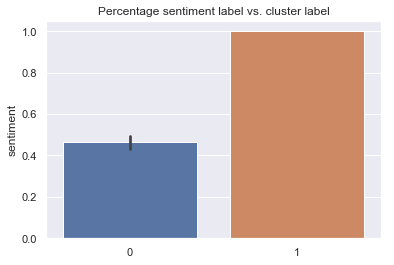

In [13]:
# extract just top 2 PCs
X_2_PCs = X[:,:2] 

k_means_cluster = KMeans(n_clusters=2, random_state=42)
cluster_labels = k_means_cluster.fit_predict(X_2_PCs)

show_cluster_stats(cluster_labels, df.sentiment)

Actually, this is even slightly better separation than using the entire raw data! The cluster labeled 1 is now 100% positives. (remember these labels are arbitrarily assigned, they just happen to align with the sentiment here) 

**UPSHOT OF THIS EXAMPLE**: Using directions of maximum variance (top PCs), we're able to find interesting structure with better quality of results and a small fraction of the original storage/compute time needed. 

Below we get some visual confirmation by plotting the top 2 PCs and cluster centers. The x-axis clearly corresponds pretty well with the spectrum of negative to positive sentiment.

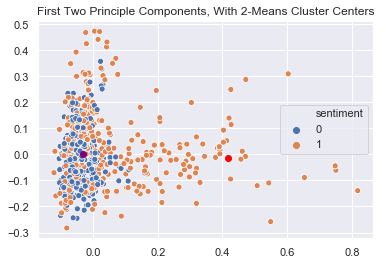

In [14]:
centers = k_means_cluster.cluster_centers_ 

sns.scatterplot(X[:,0], X[:,1], hue=df.sentiment)
plt.scatter(centers[0,0], centers[0,1],color = 'purple') 
plt.scatter(centers[1,0], centers[1,1],color = 'red')
plt.title('First Two Principle Components, With 2-Means Cluster Centers')

Taking an explicit look at some of the documents within cluster label groups is a good idea. It helps make our results much more concrete and helps to explain why we can get so much relevant information from just 1 PC. See the positive cluster label documents - there's a lot of simple positive word repetition like "great", and PCA is able to easily pick up on this as the largest variance factor. 

In [15]:
df.loc[cluster_labels == 0, ['text','sentiment']].head(5)

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
3,Tied to charger for conversations lasting more...,0
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0


In [16]:
df.loc[cluster_labels == 1, ['text','sentiment']].head(5)

,text,sentiment
2,Great for the jawbone.,1
4,The mic is great.,1
10,And the sound quality is great.,1
18,Works great!.,1
25,Great Pocket PC / phone combination.,1


See the PCA_student and/or PCA_Solution notebook under PCA_resources for more good examples.

**Tips for choosing # PCs when variance explained plots don't make it clear?**

* A **decent but not foolproof rule of thumb** is that for text data, several hundred PCs is a reasonable ballpark for the maximum you would want when clustering.
* **Sometimes the main constraint in choosing the number of PCs is compute time** - if you're clustering huge numbers of documents, the smaller the number of PCs you use, the faster you can scale.